In [1]:
"""
OBJETIVO:
Segmentar 150 clientes de una tienda en línea en grupos naturales basados en 
su comportamiento de compra, específicamente usando:
- Antigüedad (meses como cliente)
- Frecuencia de compra (compras por mes)
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import seaborn as sns

np.random.seed(42)
n_clientes = 150

datos, etiquetas_reales = make_blobs(
    n_samples=n_clientes, 
    centers=3, 
    cluster_std=0.8, 
    random_state=42
)

# Transformar la primera columna (eje X) para representar Antigüedad en meses
datos[:, 0] = datos[:, 0] * 8 + 20  # Antigüedad en meses (20-60 meses)

# Transformar la segunda columna (eje Y) para representar Frecuencia de compra
datos[:, 1] = datos[:, 1] * 2 + 3   # Frecuencia de compra (1-5 compras/mes)

# Añadir el ruido a los datos originales
ruido = np.random.normal(0, 0.5, datos.shape)
datos += ruido 

#  garantiza esto transformando cualquier valor negativo en positivo.
datos = np.abs(datos)




C:\Users\Maeva\AppData\Local\Temp\ipykernel_2688\1783718510.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Maeva\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


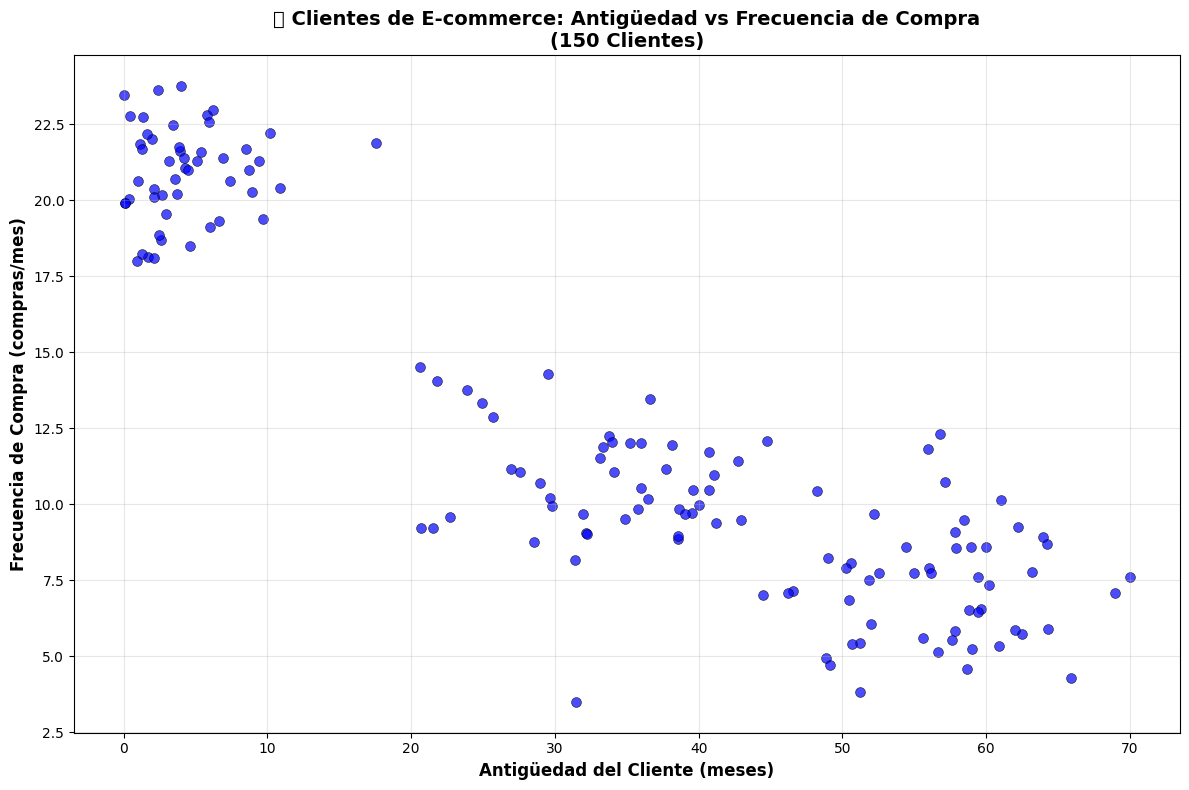

In [2]:
# Visualización inicial del dataset completo

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    datos[:, 0],           # Eje X: Antigüedad de los clientes en meses
    datos[:, 1],           # Eje Y: Frecuencia de compra en compras/mes
    alpha=0.7,             # Transparencia: 0.7 = 70% opaco, permite ver superposiciones
    s=50,                  # Tamaño de puntos: 50 pixels, tamaño óptimo para 150 puntos
    c='blue',              # Color de relleno: Azul para todos los puntos
    edgecolors='black',    # Color del borde: Negro para mejor contraste
    linewidth=0.5          # Grosor del borde: 0.5 pixels, define pero no domina
)

plt.xlabel('Antigüedad del Cliente (meses)', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia de Compra (compras/mes)', fontsize=12, fontweight='bold')
plt.title('📊 Clientes de E-commerce: Antigüedad vs Frecuencia de Compra\n(150 Clientes)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
# ESTANDARIZACIÓN DE DATOS CON StandardScaler
scaler = StandardScaler()
datos_estandarizados = scaler.fit_transform(datos)

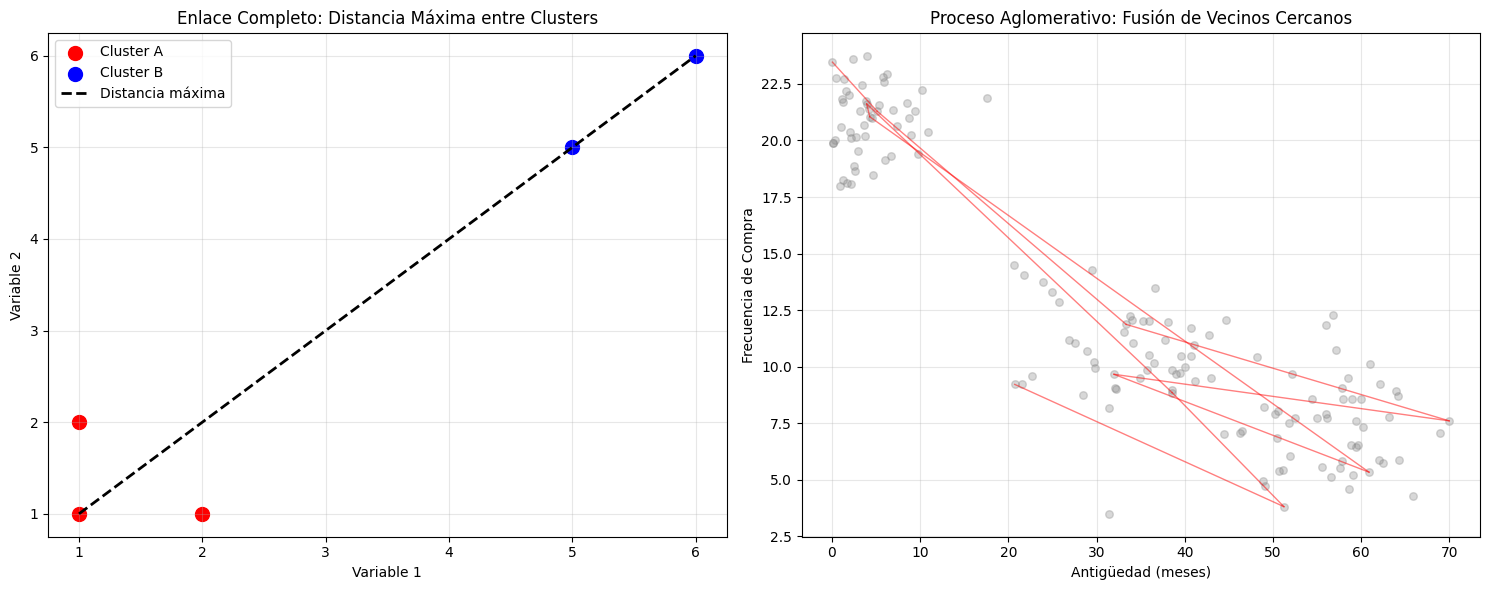

In [4]:
# Visualización del concepto de enlace completo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Ejemplo visual de enlace completo - Crear datos de ejemplo simplificados
# Cluster 1: 3 puntos cercanos entre sí formando un triángulo
ejemplo_cluster1 = np.array([[1, 1], [1, 2], [2, 1]])
# Cluster 2: 2 puntos cercanos entre sí en otra zona del gráfico
ejemplo_cluster2 = np.array([[5, 5], [6, 6]])

# Gráfico 1: Mostrar distancias entre clusters - Ejemplo conceptual
# Scatter plot del Cluster A (rojo) 
ax1.scatter(ejemplo_cluster1[:, 0], ejemplo_cluster1[:, 1], s=100, color='red', label='Cluster A')
# Scatter plot del Cluster B (azul) 
ax1.scatter(ejemplo_cluster2[:, 0], ejemplo_cluster2[:, 1], s=100, color='blue', label='Cluster B')

# Dibujar la distancia máxima (enlace completo) entre los clusters
# Seleccionar los puntos más lejanos entre clusters para mostrar distancia máxima
max_dist_punto1 = ejemplo_cluster1[0]  # Punto [1,1] del Cluster A
max_dist_punto2 = ejemplo_cluster2[1]  # Punto [6,6] del Cluster B
ax1.plot([max_dist_punto1[0], max_dist_punto2[0]],  
         [max_dist_punto1[1], max_dist_punto2[1]],  
         'k--', linewidth=2, label='Distancia máxima') 


# Configurar etiquetas y formato del primer gráfico
ax1.set_xlabel('Variable 1')
ax1.set_ylabel('Variable 2')
ax1.set_title('Enlace Completo: Distancia Máxima entre Clusters')
ax1.legend() 
ax1.grid(True, alpha=0.3)

# Gráfico 2: Proceso aglomerativo inicial - Aplicación a datos reales
# Scatter plot de todos los datos reales (color gris, puntos pequeños, transparentes)
ax2.scatter(datos[:, 0], datos[:, 1], alpha=0.3, s=30, color='gray')
ax2.set_xlabel('Antigüedad (meses)')
ax2.set_ylabel('Frecuencia de Compra')
ax2.set_title('Proceso Aglomerativo: Fusión de Vecinos Cercanos')
ax2.grid(True, alpha=0.3)

# Resaltar algunos pares cercanos para mostrar cómo comienza el algoritmo
for i in range(10):  # Iterar sobre los primeros 10 puntos
    punto = datos[i]  
    vecino_cercano = datos[(i+1) % len(datos)]  
    # Dibujar línea roja entre puntos cercanos para mostrar posibles fusiones iniciales
    ax2.plot([punto[0], vecino_cercano[0]],  
             [punto[1], vecino_cercano[1]],  
             'r-', alpha=0.5, linewidth=1)  
    
plt.tight_layout()   
plt.show()

In [5]:
# CÁLCULO DE LA MATRIZ DE ENLACE - ALGORITMO AGLOMERATIVO EN ACCIÓN

"""
Esta sección es el CORAZÓN del algoritmo de agrupamiento aglomerativo. Aquí calculamos
la matriz de enlace (linkage matrix) que contiene el historial completo de todas las 
fusiones que el algoritmo realizará

La función linkage() ejecuta el algoritmo completo de agrupamiento jerárquico aglomerativo.
Toma los datos estandarizados y calcula progresivamente las distancias entre todos los 
puntos/clusters, fusionando iterativamente los más cercanos según el método especificado.
"""

Z = linkage(datos_estandarizados, method='complete') 
print(f"   • Dimensiones: {Z.shape} ({(Z.shape[0])} fusiones registradas)")


   • Dimensiones: (149, 4) (149 fusiones registradas)


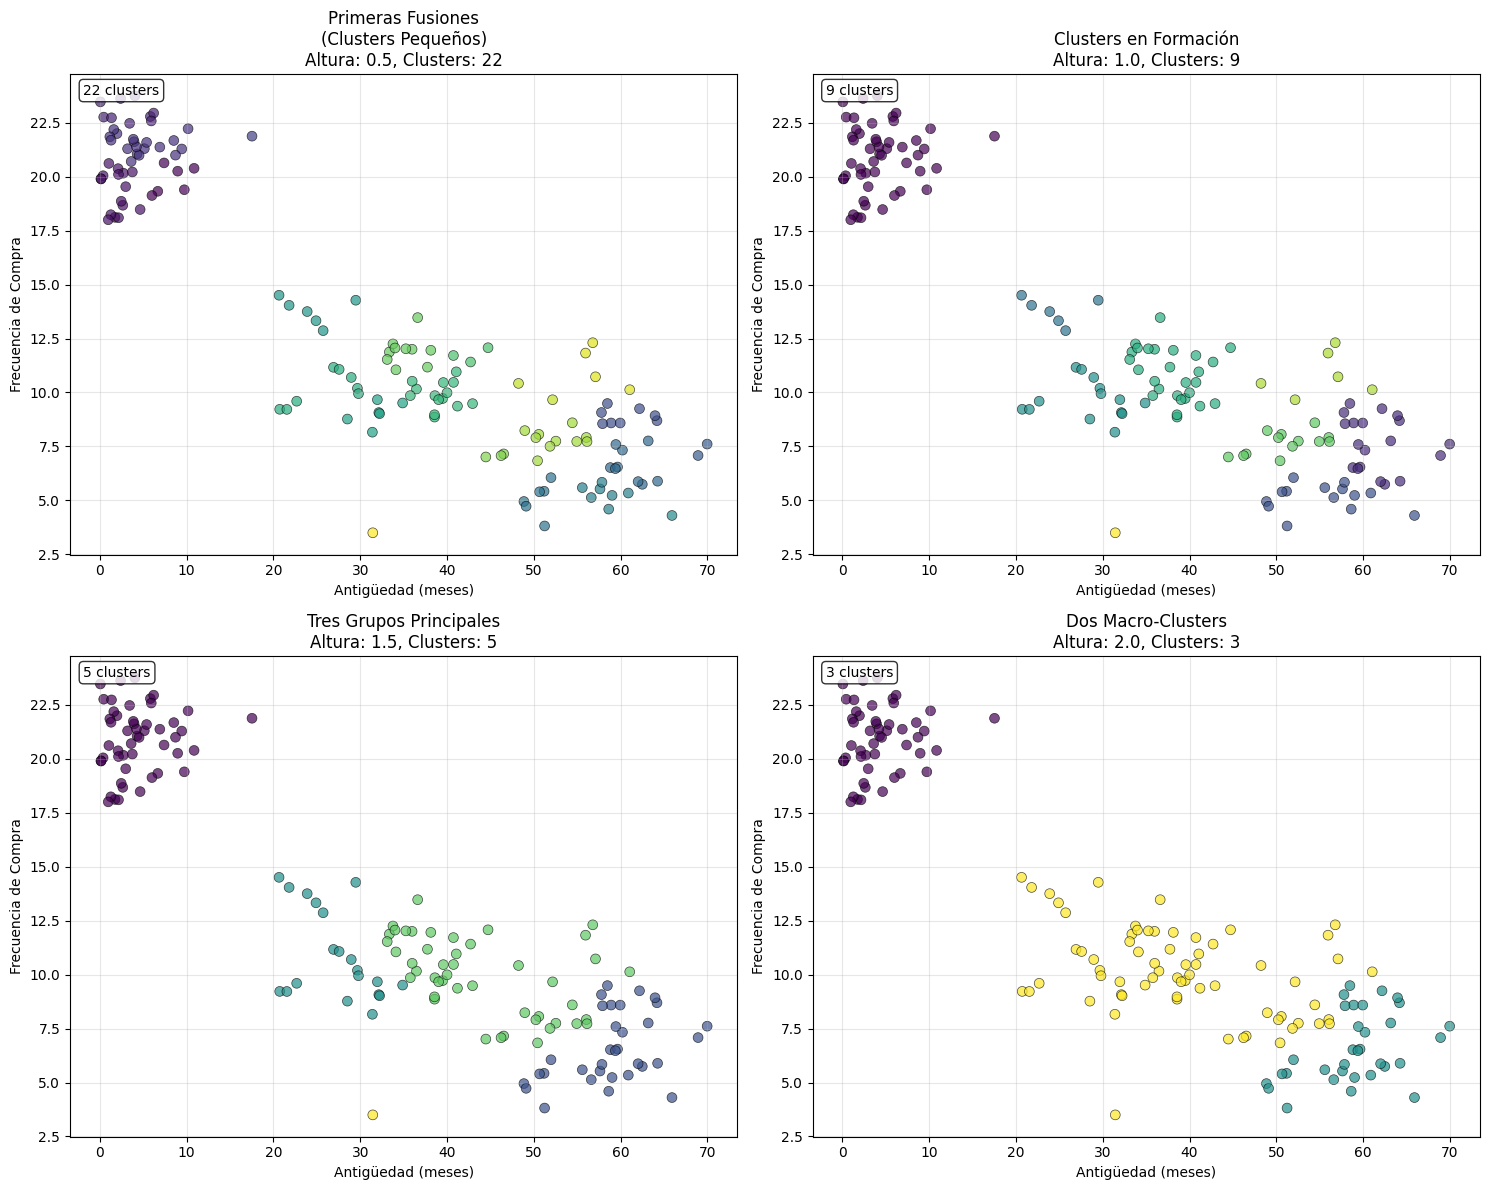

In [6]:
# VISUALIZACIÓN DEL PROCESO DE AGRUPAMIENTO EN DIFERENTES ETAPAS
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
alturas_corte = [0.5, 1.0, 1.5, 2.0]
titulos = [
    'Primeras Fusiones\n(Clusters Pequeños)',      # Altura 0.5: Fusión de puntos muy cercanos
    'Clusters en Formación',                       # Altura 1.0: Consolidación intermedia
    'Tres Grupos Principales',                     # Altura 1.5: Estructura óptima visible
    'Dos Macro-Clusters'                           # Altura 2.0: Fusión de grupos principales
]
for i, (ax, altura, titulo) in enumerate(zip(axes.flat, alturas_corte, titulos)):
    clusters = fcluster(Z, altura, criterion='distance')
    n_clusters = len(np.unique(clusters))     
    scatter = ax.scatter(datos[:, 0], datos[:, 1], c=clusters, 
                        cmap='viridis', alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    # CONFIGURAR ETIQUETAS Y FORMATO DEL SUBGRÁFICO
    ax.set_xlabel('Antigüedad (meses)')       
    ax.set_ylabel('Frecuencia de Compra')     
    ax.set_title(f'{titulo}\nAltura: {altura}, Clusters: {n_clusters}')  # Título informativo
    ax.grid(True, alpha=0.3) 
    ax.text(0.02, 0.98, f'{n_clusters} clusters', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()  
plt.show()  

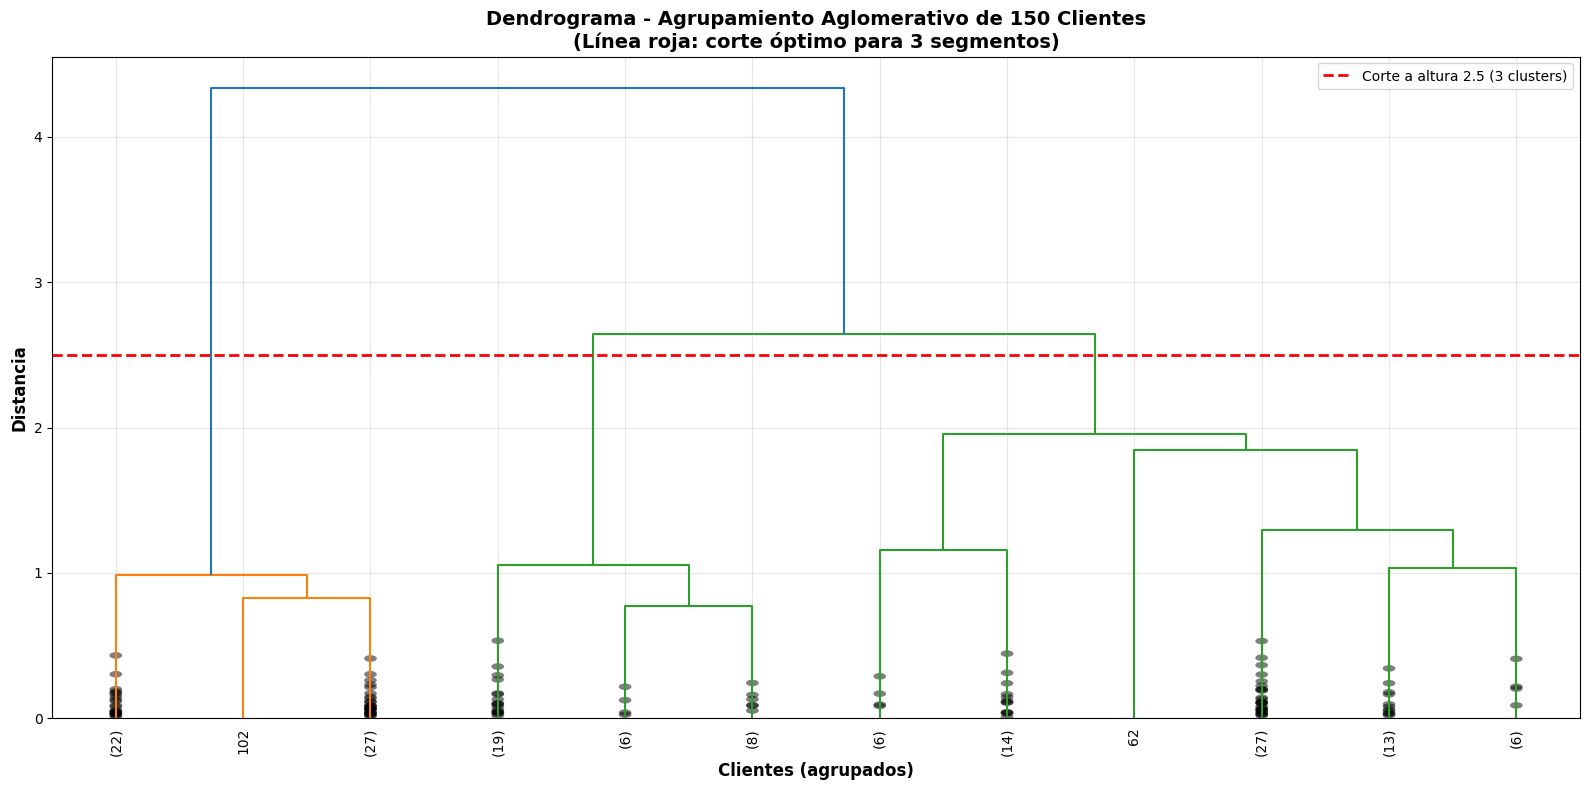

In [7]:
# CREAR DENDROGRAMA COMPLETO - VISUALIZACIÓN JERÁRQUICA

plt.figure(figsize=(16, 8))
dendrogram(Z, 
           truncate_mode='lastp', 
           p=12, 
           show_leaf_counts=True, 
           leaf_rotation=90, 
           leaf_font_size=10,
           show_contracted=True)

altura_corte = 2.5

plt.axhline(y=altura_corte, color='r', linestyle='--', linewidth=2, 
           label=f'Corte a altura {altura_corte} (3 clusters)')
plt.xlabel('Clientes (agrupados)', fontsize=12, fontweight='bold')  
plt.ylabel('Distancia', fontsize=12, fontweight='bold')             
plt.title('Dendrograma - Agrupamiento Aglomerativo de 150 Clientes\n(Línea roja: corte óptimo para 3 segmentos)', 
          fontsize=14, fontweight='bold')  
plt.legend()     
plt.grid(True, alpha=0.3) 
plt.tight_layout() 
plt.show()   




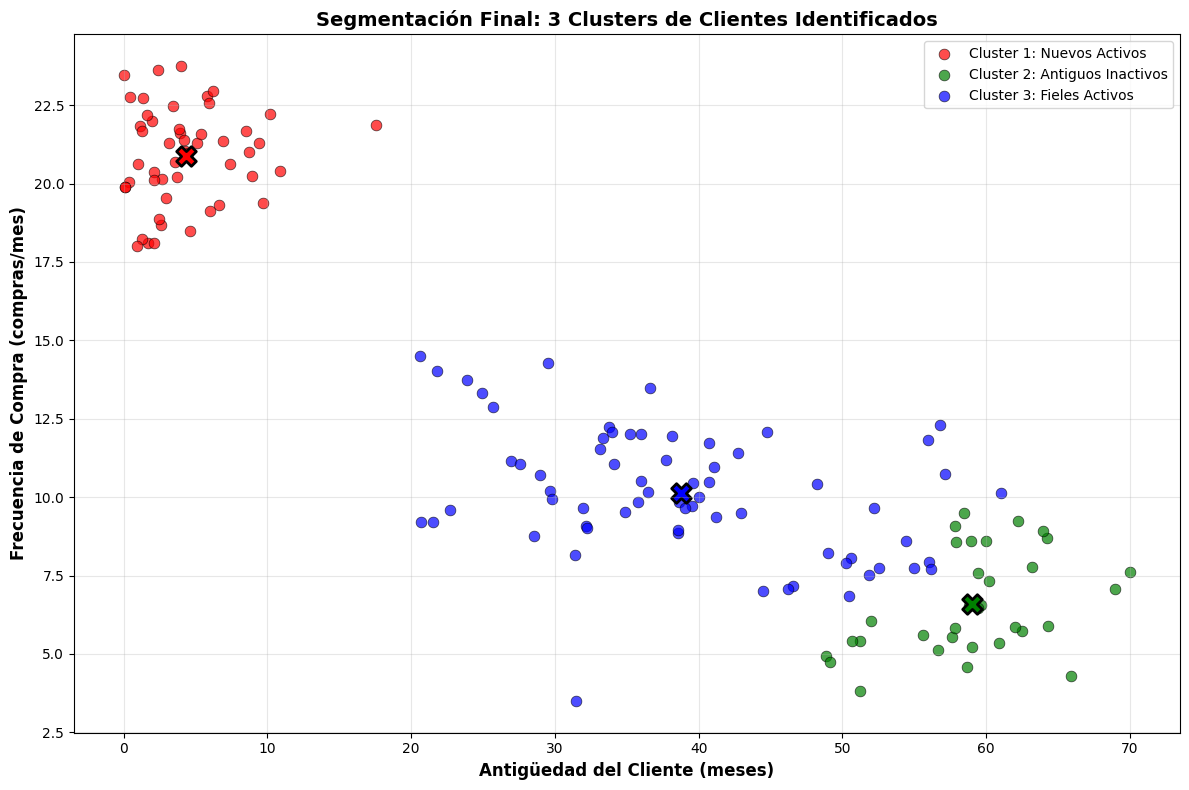

In [9]:
# ASIGNACIÓN FINAL DE CLUSTERS BASADA EN EL CORTE DEL DENDROGRAMA
clusters_finales = fcluster(Z, t=altura_corte, criterion='distance')

# CREAR DATAFRAME CON RESULTADOS PARA ANÁLISIS ESTADÍSTICO
df_clientes = pd.DataFrame({
    'antiguedad': datos[:, 0],           
    'frecuencia_compra': datos[:, 1],    
    'cluster': clusters_finales      
})

analisis_clusters = df_clientes.groupby('cluster').agg({
    'antiguedad': ['mean', 'std', 'count'],          # Estadísticas de antigüedad
    'frecuencia_compra': ['mean', 'std']             # Estadísticas de frecuencia
}).round(2)

plt.figure(figsize=(12, 8))
colores = ['red', 'green', 'blue']  # Esquema de colores distintivo para cada cluster
nombres_clusters = [
    'Cluster 1: Nuevos Activos',    # Interpretación comercial del cluster 1
    'Cluster 2: Antiguos Inactivos',         # Interpretación comercial del cluster 2
    'Cluster 3: Fieles Activos'      # Interpretación comercial del cluster 3
]

for i, cluster_id in enumerate(np.unique(clusters_finales)):
    cluster_data = df_clientes[df_clientes['cluster'] == cluster_id]
    plt.scatter(cluster_data['antiguedad'], cluster_data['frecuencia_compra'],
               c=colores[i], label=nombres_clusters[i], alpha=0.7, s=60, 
               edgecolors='black', linewidth=0.5)
    centroide = [
        cluster_data['antiguedad'].mean(),           # Promedio de antigüedad
        cluster_data['frecuencia_compra'].mean()     # Promedio de frecuencia
    ]
    plt.scatter(centroide[0], centroide[1], c=colores[i], marker='X', s=200, 
               edgecolors='black', linewidth=2)
    

plt.xlabel('Antigüedad del Cliente (meses)', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia de Compra (compras/mes)', fontsize=12, fontweight='bold')
plt.title('Segmentación Final: 3 Clusters de Clientes Identificados', 
          fontsize=14, fontweight='bold')
plt.legend()        
plt.grid(True, alpha=0.3)  
plt.tight_layout() 
plt.show() 

In [10]:
# Analisis detallado de cada segmento - CÓDIGO CORREGIDO

print("\n" + "=" * 70)
print("CARACTERIZACIÓN DETALLADA DE SEGMENTOS (AJUSTADA A NUEVOS NOMBRES)")
print("=" * 70)


segmentos_detallados = [
    {
        "cluster_id": 1,
        "nombre": "CLUSTER 1: NUEVOS ACTIVOS", 
        "caracteristicas": "Clientes nuevos (baja antigüedad) y ALTA frecuencia de compra",
        "antiguedad_promedio": df_clientes[df_clientes['cluster'] == 1]['antiguedad'].mean(),
        "frecuencia_promedio": df_clientes[df_clientes['cluster'] == 1]['frecuencia_compra'].mean(),
        "tamano": len(df_clientes[df_clientes['cluster'] == 1]),
        "estrategia": "Incentivos de Retención temprana y escalamiento de valor" # Nueva estrategia para Nuevos Activos
    },
    {
        "cluster_id": 2,
        "nombre": "CLUSTER 2: ANTIGUOS INACTIVOS", 
        "caracteristicas": "Clientes muy antiguos (alta antigüedad) con BAJA o decreciente frecuencia",
        "antiguedad_promedio": df_clientes[df_clientes['cluster'] == 2]['antiguedad'].mean(),
        "frecuencia_promedio": df_clientes[df_clientes['cluster'] == 2]['frecuencia_compra'].mean(),
        "tamano": len(df_clientes[df_clientes['cluster'] == 2]),
        "estrategia": "Campañas agresivas de reactivación y ofertas de 'Última oportunidad'" # Nueva estrategia para Antiguos Inactivos
    },
    {
        "cluster_id": 3,
        "nombre": "CLUSTER 3: FIELES ACTIVOS",
        "caracteristicas": "Clientes con antigüedad media/alta y la más ALTA frecuencia de compra (el mejor segmento)",
        "antiguedad_promedio": df_clientes[df_clientes['cluster'] == 3]['antiguedad'].mean(),
        "frecuencia_promedio": df_clientes[df_clientes['cluster'] == 3]['frecuencia_compra'].mean(),
        "tamano": len(df_clientes[df_clientes['cluster'] == 3]),
        "estrategia": "Programas de lealtad, ofertas exclusivas y comunicación VIP" # Nueva estrategia para Fieles Activos
    }
]

for segmento in segmentos_detallados:
    print(f"\n{segmento['nombre']}")
    print("-" * 50)
    print(f"• Cluster ID Interno: {segmento['cluster_id']}")
    print(f"• Características: {segmento['caracteristicas']}")
    print(f"• Antigüedad promedio: {segmento['antiguedad_promedio']:.1f} meses")
    print(f"• Frecuencia promedio: {segmento['frecuencia_promedio']:.1f} compras/mes")
    print(f"• Tamaño del segmento: {segmento['tamano']} clientes")
    print(f"• Estrategia recomendada: {segmento['estrategia']}")


CARACTERIZACIÓN DETALLADA DE SEGMENTOS (AJUSTADA A NUEVOS NOMBRES)

CLUSTER 1: NUEVOS ACTIVOS
--------------------------------------------------
• Cluster ID Interno: 1
• Características: Clientes nuevos (baja antigüedad) y ALTA frecuencia de compra
• Antigüedad promedio: 4.3 meses
• Frecuencia promedio: 20.9 compras/mes
• Tamaño del segmento: 50 clientes
• Estrategia recomendada: Incentivos de Retención temprana y escalamiento de valor

CLUSTER 2: ANTIGUOS INACTIVOS
--------------------------------------------------
• Cluster ID Interno: 2
• Características: Clientes muy antiguos (alta antigüedad) con BAJA o decreciente frecuencia
• Antigüedad promedio: 59.0 meses
• Frecuencia promedio: 6.6 compras/mes
• Tamaño del segmento: 33 clientes
• Estrategia recomendada: Campañas agresivas de reactivación y ofertas de 'Última oportunidad'

CLUSTER 3: FIELES ACTIVOS
--------------------------------------------------
• Cluster ID Interno: 3
• Características: Clientes con antigüedad media/alta 